In [1920]:
%matplotlib inline

import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('error')

class NN(object):
    def __init__(self, size_layers=[784, 16, 16, 10], datapath=None, modelpath=None):
        self.data = np.load(datapath)
        self.size_layers = size_layers
        
        # The cache would be used to store forward feed activations and preactivations values 
        self.cache = {
            'activations': [],
            'preactivations': []
        }
        
        # Data structure to hold the params of the model
        self.theta = {
            'b': [],
            'w': []
        }
        
        # Data structure to hold the gradients calculated during backprop
        self.grads = {
            'b': [],
            'w': []
        }

In [1921]:
def initialize_zero_weights(self):
    size_next_layers = self.size_layers.copy()
    size_next_layers.pop(0)
    
    for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
        self.theta['w'].append(np.zeros((size_next_layer, size_layer)))
        self.theta['b'].append(np.zeros((1, size_next_layer)))
        
        self.grads['w'].append(np.zeros((size_next_layer, size_layer)))
        self.grads['b'].append(np.zeros((1, size_next_layer)))

In [1922]:
def initialize_normal_weights(self):
    size_next_layers = self.size_layers.copy()
    size_next_layers.pop(0)

    for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
        self.theta['w'].append(np.random.normal(size=(size_next_layer, size_layer)))
        self.theta['b'].append(np.zeros((1, size_next_layer)))

        self.grads['w'].append(np.random.normal(size=(size_next_layer, size_layer)))
        self.grads['b'].append(np.zeros((1, size_next_layer)))

In [1923]:
def initialize_glorot_weights(self):
    pass

In [1924]:
def forward(self, X):
    '''
    Forward propagation
    params:
        X: N by k matrix
        where
            N: number of samples
            k: dimension of sample
    returns: output is a N by o matrix where o is the output dimension specified
    in mlp initialization
    '''
    n_layers = len(self.size_layers)
    input_layer = X
    
    # Adding input in activations needed for gradient descent
    self.cache['activations'].append(X)
    
    # Index stops before the last layer as we'd need to treat it differently
    for layer_idx in range(n_layers - 2):
        
        # Multiply the input by the weights
        pre_act_layer = np.matmul(input_layer,  self.theta['w'][layer_idx].transpose()) + self.theta['b'][layer_idx]
        # Apply activation function
        output_layer = activation(self, pre_act_layer)
        
        self.cache['preactivations'].append(pre_act_layer)
        self.cache['activations'].append(output_layer)
        
        input_layer = output_layer
    
    # Final layer with softmax activation
    # Multiply the input by the weights
    pre_act_layer = np.matmul(input_layer, self.theta['w'][-1].transpose()) + self.theta['b'][-1]
    # Apply activation function
    output_layer = softmax(self, pre_act_layer)

    self.cache['preactivations'].append(pre_act_layer)
    self.cache['activations'].append(output_layer)
    
    return output_layer

In [1925]:
def activation(self, input):
    zero_aux = np.zeros(input.shape)
    meta_z = np.stack((input , zero_aux), axis = -1)
    
    return np.max(meta_z, axis = -1)

In [1926]:
def activation_prime(self, input):
    result = input.copy()
    result[result<=0] = 0
    result[result>0] = 1

    return result

In [1927]:
def softmax(self, input):
    '''
    params:
        input: N by k matrix
        where
            N: number of samples
            k: dimension of each sample
    returns: a N by k matrix representing the probability distribution 
        of each sample
    '''
    e_x = np.exp(input - np.max(input, axis=1, keepdims=1))
    return e_x / e_x.sum(axis=1, keepdims=1)

In [1928]:
def loss(self, predictions, targets):
    '''
    Takes a batch of predictions and gets the cross entropy
    params:
        predictions: N by k matrix
        where
            N: number of samples
            k: dimension of each sample
        targets: N by 1 matrix containing label of each one
        where 
            N: number of samples
    returns: a scalar which is the loss value            
    '''
    N = predictions.shape[0] # batch size
    k = predictions.shape[1] # numb of classes
    
    cross_entropy_softmax_prime = np.multiply(np.eye(k)[targets], np.log(predictions))
    return np.sum(-1*cross_entropy_softmax_prime)/N

In [1929]:
def loss_prime(self, predictions, targets):
    N = predictions.shape[0] # batch size
    k = predictions.shape[1] # numb of classes
    
    return np.sum(predictions - np.eye(k)[targets], axis=0, keepdims=1)/N

In [1930]:
def backward(self, Y):
    '''
    Backward propagation
    params:
        Y: N by 1 matrix
        where
            N: number of samples
            column: is the label of the samples
    '''
    N = Y.shape[0]
    n_layers = len(self.size_layers)
    
    delta = loss_prime(self, self.cache['activations'][-1], Y)
    
    self.grads['b'][-1] = delta
    self.grads['w'][-1] = np.dot(delta.transpose(), np.sum(self.cache['activations'][-2], axis=0, keepdims=1)/N)
    
    for l in range(2, n_layers):
        z = self.cache['preactivations'][-l]
        o = activation_prime(self, z)
        
        delta = np.multiply(np.dot(delta, self.theta['w'][-l+1]), np.sum(o, axis=0, keepdims=1)/N)
        
        self.grads['b'][-l] = delta
        self.grads['w'][-l] = np.dot(delta.transpose(), np.sum(self.cache['activations'][-l-1], axis=0, keepdims=1)/N)

In [1931]:
def update(self, eta, lmbda, batch_size):
    n_layers = len(self.size_layers)
    
    for layer_idx in range(n_layers - 1):
        grad_w = self.grads['w'][layer_idx]
        grad_b = self.grads['b'][layer_idx]
        w = self.theta['w'][layer_idx]
        b = self.theta['b'][layer_idx]
        
        self.theta['w'][layer_idx] = w - (eta/batch_size)*grad_w - lmbda*w
        self.theta['b'][layer_idx] = b - (eta/batch_size)*grad_b - lmbda*b

In [1932]:
def train(self, eta, epoch=20, batch_size=1000, lmbda=0.5):
    losses = []
    
    for i in range(epoch):
        train_set, valid_set, test_set = self.data
        
        X, Y = train_set
        
        mini_batches = [
            (X[k:k+batch_size], Y[k:k+batch_size]) for k in range(0, len(X), batch_size)
        ]
        
        for X, Y in mini_batches:
            forward(mlp, X)
            backward(mlp, Y)
            update(mlp, eta, lmbda, batch_size=batch_size)
        
        Y_h = forward(mlp, X)
        losses.append(loss(mlp, Y_h, Y))

    return losses

In [1933]:
def test(self):
    pass

## Question1
1.

Initializing weights to zero, with 0.5 as learning rate and no minibatch

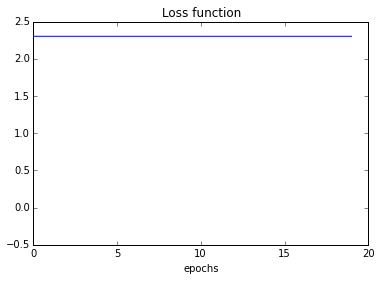

In [1934]:
datapath = 'data/mnist.pkl.npy'
modelpath = 'model/mlp.pkl.npy'

eta = 0.5
batch_size = 1000
epoch = 20
lmbda = 0.005

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 16, 16, 10])

initialize_zero_weights(mlp)
losses = train(mlp, eta, epoch=epoch, batch_size=batch_size, lmbda=lmbda)

plt.plot(range(len(losses)), losses)
plt.xlabel('epochs') 
plt.title('Loss function')
plt.axhline(0, color='white')
plt.axvline(0, color='white')
plt.show()

Initializing normally distributed weights

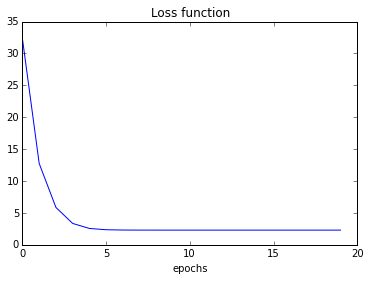

In [1935]:
datapath = 'data/mnist.pkl.npy'
modelpath = 'model/mlp.pkl.npy'

eta = 0.5
batch_size = 1000
epoch = 20
lmbda = 0.005

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 16, 16, 10])

initialize_normal_weights(mlp)
losses = train(mlp, eta, epoch=epoch, batch_size=batch_size, lmbda=lmbda)

plt.plot(range(len(losses)), losses)
plt.xlabel('epochs') 
plt.title('Loss function')
plt.axhline(0, color='white')
plt.axvline(0, color='white')
plt.show()